# Fitting pixel grids to flat-field data using weak_sauce

In [2]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter

from scipy.ndimage.filters import gaussian_filter
from scipy.signal import resample

In this notebook, we demonstrate how our weak_sauce algorithm can be used to:
1. Create a pixel grid with pure E-mode distortions
2. Recover this model from synthesized flat-field data.

These are the main functionalities the casual user will want to understand. For a more detailed demonstration on some "under-the-hood" features of the code, see interactive_documentation.ipynb

## Creating a pixel grid with pure E-mode distortions

### Step 1: Compute the gradient of a scalar field

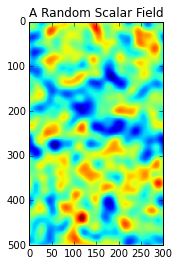

In [3]:
y_size = 500
x_size = 300
data = np.random.normal(size=(y_size,x_size))
smoothed = gaussian_filter(data,sigma=10,mode='wrap')
plt.imshow(smoothed,interpolation='None')
plt.title('A Random Scalar Field')

Compute the gradient:

In [5]:
gradX, gradY = np.gradient(smoothed)
gradX *= 5
gradY *= 5
X, Y = np.meshgrid(np.arange(x_size),np.arange(y_size))

### Step 2: Create a pixel grid model from the computed gradient

Create a rectilinear Source (essentially a pixel grid--we kind of outgrew our initial abstractions...)

In [8]:
source = Source(num_x=y_size,num_y=x_size)

Distort the vertices according to the computed gradients:

In [9]:
source.vertices[:,:,0] += gradX
source.vertices[:,:,1] += gradY

Update the pixel centroids (since we changed the vertex locations):

In [10]:
source.update_centroids()

The default flux level of a "source" is zero, so we need to create an illuminator (default flux level = 1) to compute pixel areas (stored as "fluxes"):

In [11]:
areaFinder = UniformIlluminationMover()

Now we pair the distorted grid and the uniform flux illuminator into a "moveable grid", a pairing that lets us apply the mover to the source.

In [12]:
distorted_grid = MoveableGrid(source,areaFinder)

Now that the mover and source are paired, we can apply the illumination to the pixel grid:

In [13]:
distorted_grid.step()

## Recovering the input pixel grid model from a synthetic flat field

Create a new rectilinear grid as the starting point for the fit:

In [14]:
grid_to_fit = Source(num_x=y_size,num_y=x_size)

Let's save the fluxes from the distorted array we computed in step one. These flat field fluxes will be the target of our fit using the new grid.

In [15]:
distorted_flat_field = distorted_grid.source.fluxes

Instantiate a FlatFitter to fit a pixel grid model to the flat field data. Note that step size, maxiter, etc. may need to be tuned for ideal convergence:

In [16]:
fitter = FlatFitter(grid_to_fit,distorted_flat_field,step_size=0.5)

Finally, run the fitter using the .fit() method. If verbose, the output gives the step number, log-likelihood, and deltas for [x-vertex positions, y-vertex positions, fluxes] at every step.

In [27]:
fitter.fit(maxiter=1000,verbose=True)

0
-0.208979741448
[  4.44705454e-02   2.15089135e-02   2.87004146e-05]
1
-0.203219865758
[  6.20460695e-03   2.43161019e-02   2.78752149e-05]
2
-0.197678202133
[  2.80135087e-02   7.90943885e-02   2.71056130e-05]
3
-0.192343544506
[  2.46880721e-01   1.57783822e-02   2.63827208e-05]
4
-0.187205541232
[  6.53111493e-03   1.68998667e-02   2.56999116e-05]
5
-0.182254585791
[  9.75152332e-03   1.22216029e-02   2.50521003e-05]
6
-0.177481729894
[  1.74677407e-01   1.52309448e-02   2.44352894e-05]
7
-0.172878612813
[  2.79672049e-02   1.87194467e-02   2.38462783e-05]
8
-0.168437402766
[  1.32668701e-02   1.24317453e-02   2.32824419e-05]
9
-0.164150747497
[  7.84575157e-03   1.60588804e-02   2.27416092e-05]
10
-0.160011732016
[  1.67677590e-01   2.28100723e-02   2.22219366e-05]
11
-0.156013842008
[  1.29689297e-02   5.26453629e-03   2.17218610e-05]
12
-0.152150931838
[  6.91228582e-03   1.02083436e-02   2.12400162e-05]
13
-0.148417196303
[  4.36742383e-03   7.64571863e-03   2.07752221e-05]
14

-0.0243041375626
[  1.55635069e-03   1.59556815e-03   4.37071133e-06]
117
-0.0239927061004
[  2.10136093e-03   1.33666854e-03   4.32292343e-06]
118
-0.0236866642888
[  3.87091175e-03   1.31267909e-03   4.27588320e-06]
119
-0.0233858946319
[  2.43401775e-02   1.42629457e-03   4.22957725e-06]
120
-0.0230902827203
[  4.97196853e-03   1.77761836e-03   4.18398922e-06]
121
-0.0227997171362
[  2.09251289e-01   2.98525432e-03   4.13910642e-06]
122
-0.0225140893625
[  5.31137137e-03   6.44873880e-02   4.09491324e-06]
123
-0.022233293694
[  6.81537502e-03   3.25097211e-03   4.05139764e-06]
124
-0.0219572271529
[  3.08183152e-03   4.54037363e-03   4.00854471e-06]
125
-0.0216857894059
[  8.67381303e-03   7.73329614e-03   3.96634302e-06]
126
-0.0214188826852
[  4.16772355e-03   4.69062678e-03   3.92477833e-06]
127
-0.0211564117118
[  3.72454826e-03   4.86388568e-02   3.88383981e-06]
128
-0.0208982836214
[  1.29189821e-02   4.64112394e-03   3.84351382e-06]
129
-0.0206444078931
[  2.46228214e-03   6.

[  3.44570477e-04   4.99566338e-04   1.64188043e-06]
229
-0.00749171763237
[  3.36048532e-04   4.95469635e-04   1.63051328e-06]
230
-0.00742824648492
[  3.34135893e-04   5.01647724e-04   1.61926578e-06]
231
-0.00736550043954
[  3.35496772e-04   5.12402821e-04   1.60813709e-06]
232
-0.00730346909398
[  3.43823529e-04   5.37399961e-04   1.59712492e-06]
233
-0.00724214222622
[  3.56498072e-04   5.72261032e-04   1.58622846e-06]
234
-0.0071815097908
[  3.78559097e-04   6.34262126e-04   1.57544550e-06]
235
-0.00712156191526
[  4.08598415e-04   7.27180616e-04   1.56477527e-06]
236
-0.00706228889666
[  4.54854564e-04   9.00341354e-04   1.55421559e-06]
237
-0.00700368119813
[  5.19949203e-04   1.23411584e-03   1.54376575e-06]
238
-0.0069457294456
[  6.23191363e-04   2.18982774e-03   1.53342363e-06]
239
-0.00688842442448
[  7.88878461e-04   1.24110427e-02   1.52318854e-06]
240
-0.00683175707651
[  1.10782013e-03   3.28510587e-03   1.51305843e-06]
241
-0.00677571849667
[  1.89141771e-03   1.50194

[  2.42354615e-04   2.64766501e-04   8.71353989e-07]
340
-0.00331406861281
[  2.25174849e-04   2.65228134e-04   8.67389516e-07]
341
-0.00329304874572
[  2.09908098e-04   2.65200700e-04   8.63459949e-07]
342
-0.00327221050452
[  1.97706944e-04   2.66888875e-04   8.59564566e-07]
343
-0.00325155193246
[  1.86443864e-04   2.68086098e-04   8.55703455e-07]
344
-0.00323107109809
[  1.77425014e-04   2.71120544e-04   8.51875909e-07]
345
-0.00321076609489
[  1.68801422e-04   2.73705388e-04   8.48082018e-07]
346
-0.00319063504088
[  1.61933477e-04   2.78312456e-04   8.44321088e-07]
347
-0.00317067607826
[  1.55136628e-04   2.82572247e-04   8.40593212e-07]
348
-0.00315088737303
[  1.49786015e-04   2.89135874e-04   8.36897708e-07]
349
-0.00313126711465
[  1.44302403e-04   2.95552241e-04   8.33234673e-07]
350
-0.00311181351567
[  1.40059083e-04   3.04714228e-04   8.29603436e-07]
351
-0.00309252481141
[  1.35549014e-04   3.14103032e-04   8.26004098e-07]
352
-0.00307339925959
[  1.32136400e-04   3.269

-0.00176968867155
[  3.48471709e-04   1.53752318e-03   5.90225251e-07]
452
-0.00176083154485
[  3.90766954e-04   3.49179980e-03   5.88846256e-07]
453
-0.00175203617124
[  4.45249296e-04   1.02593226e-02   5.87483031e-07]
454
-0.00174330201263
[  5.22173334e-04   2.17847002e-03   5.86135283e-07]
455
-0.00173462853652
[  6.33434413e-04   1.48793380e-03   5.84803153e-07]
456
-0.00172601521594
[  8.16345020e-04   1.68357714e-03   5.83486353e-07]
457
-0.00171746152936
[  1.15835468e-03   3.49163877e-03   5.82185023e-07]
458
-0.00170896696065
[  2.05338883e-03   1.04157180e-02   5.80898880e-07]
459
-0.00170053099899
[  9.60095863e-03   2.11126680e-03   5.79628064e-07]
460
-0.00169215313883
[  3.54152778e-03   1.20758550e-03   5.78372295e-07]
461
-0.0016838328798
[  1.51358955e-03   8.60344465e-04   5.77131713e-07]
462
-0.0016755697267
[  9.89708164e-04   6.77979206e-04   5.75906042e-07]
463
-0.00166736318935
[  7.64488438e-04   5.63242871e-04   5.74695422e-07]
464
-0.00165921278263
[  6.5978

-0.00106635904491
[  1.09760223e-04   8.31304363e-04   5.20993885e-07]
564
-0.00106202551467
[  1.11175768e-04   9.74322825e-04   5.21077104e-07]
565
-0.00105771713191
[  1.13478788e-04   1.24307448e-03   5.21172054e-07]
566
-0.00105343371228
[  1.15092722e-04   1.82315617e-03   5.21278630e-07]
567
-0.00104917507301
[  1.17691611e-04   3.57987467e-03   5.21396924e-07]
568
-0.00104494103296
[  1.19540143e-04   3.08466575e-02   5.21526833e-07]
569
-0.00104073141254
[  1.22487170e-04   3.98077670e-03   5.21668447e-07]
570
-0.00103654603376
[  1.24616912e-04   1.90067632e-03   5.21821668e-07]
571
-0.00103238472015
[  1.27978845e-04   1.25611056e-03   5.21986585e-07]
572
-0.00102824729677
[  1.30450641e-04   9.45980773e-04   5.22163099e-07]
573
-0.00102413359021
[  1.34314068e-04   7.59346265e-04   5.22351300e-07]
574
-0.00102004342856
[  1.37208626e-04   6.38998199e-04   5.22551093e-07]
575
-0.00101597664139
[  1.41687835e-04   5.51358293e-04   5.22762564e-07]
576
-0.00101193305975
[  1.45

-0.000710700021276
[  1.03266513e-04   2.96257989e-03   5.99379255e-07]
673
-0.000708287968761
[  1.01392392e-04   5.50226393e-02   6.00768703e-07]
674
-0.00070588785042
[  1.01529982e-04   4.93624006e-03   6.02171060e-07]
675
-0.000703499590689
[  1.00232354e-04   7.10286315e-03   6.03586388e-07]
676
-0.000701123114579
[  1.01145574e-04   3.69965965e-03   6.05014683e-07]
677
-0.000698758347667
[  1.00416568e-04   1.69305022e-02   6.06456007e-07]
678
-0.000696405216097
[  1.02132884e-04   2.44760482e-03   6.07910358e-07]
679
-0.00069406364657
[  1.01991295e-04   1.45259561e-03   6.09377797e-07]
680
-0.000691733566343
[  1.04566949e-04   1.09647740e-03   6.10858325e-07]
681
-0.00068941490322
[  1.05060824e-04   9.21894252e-04   6.12352001e-07]
682
-0.000687107585552
[  1.08586800e-04   8.36805164e-04   6.13858827e-07]
683
-0.000684811542228
[  1.09800200e-04   8.07506968e-04   6.15378864e-07]
684
-0.000682526702674
[  1.14413831e-04   8.37424411e-04   6.16912115e-07]
685
-0.000680252996

-0.000503400241781
[  1.52252663e-04   7.46435830e-04   8.37899717e-07]
783
-0.000501947842866
[  1.43380031e-04   9.98587853e-04   8.40958898e-07]
784
-0.000500501652432
[  1.38691026e-04   1.59182604e-03   8.44036326e-07]
785
-0.000499061636106
[  1.31339353e-04   3.98781468e-03   8.47132075e-07]
786
-0.000497627759744
[  1.27659340e-04   7.26384763e-03   8.50246214e-07]
787
-0.000496199989433
[  1.21452900e-04   1.91624244e-03   8.53378816e-07]
788
-0.000494778291484
[  1.18520911e-04   1.12484324e-03   8.56529953e-07]
789
-0.000493362632434
[  1.13199546e-04   8.05247734e-04   8.59699698e-07]
790
-0.000491952979044
[  1.10835242e-04   6.44403511e-04   8.62888123e-07]
791
-0.000490549298293
[  1.06212995e-04   5.43858646e-04   8.66095303e-07]
792
-0.000489151557385
[  1.04288111e-04   4.84255690e-04   8.69321312e-07]
793
-0.000487759723739
[  1.00228459e-04   4.41852940e-04   8.72566224e-07]
794
-0.00048637376499
[  9.86495239e-05   4.17763523e-04   8.75830114e-07]
795
-0.0004849936

-0.000372711954262
[  5.90321504e-05   3.64606287e-04   1.31321809e-06]
895
-0.000371784404825
[  5.92836264e-05   3.89462549e-04   1.31887826e-06]
896
-0.000370860318083
[  6.01435715e-05   4.23509005e-04   1.32456794e-06]
897
-0.000369939677147
[  6.04530884e-05   4.65930224e-04   1.33028725e-06]
898
-0.00036902246523
[  6.13745023e-05   5.24786382e-04   1.33603632e-06]
899
-0.000368108665647
[  6.17475805e-05   6.03350804e-04   1.34181530e-06]
900
-0.000367198261809
[  6.27374298e-05   7.20820947e-04   1.34762433e-06]
901
-0.000366291237227
[  6.31805332e-05   9.02910407e-04   1.35346353e-06]
902
-0.000365387575513
[  6.42469030e-05   1.24311460e-03   1.35933306e-06]
903
-0.000364487260372
[  6.47676297e-05   2.08413670e-03   1.36523304e-06]
904
-0.000363590275608
[  6.59199534e-05   8.55931081e-03   1.37116363e-06]
905
-0.000362696605122
[  6.65272737e-05   3.91241850e-03   1.37712495e-06]
906
-0.000361806232909
[  6.77766221e-05   2.80845353e-03   1.38311717e-06]
907
-0.0003609191

## Results show that the output fluxes and vertex positions match the input, as desired

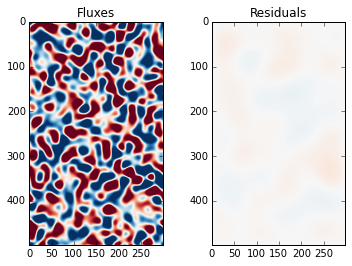

In [29]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(distorted_grid.source.fluxes-1,vmin=-.002,vmax=.002,cmap='RdBu_r')
axs[0].set_title('Fluxes')
axs[1].imshow((grid_to_fit.fluxes-grid.source.fluxes),vmin=-.002,vmax=.002,cmap='RdBu_r')
axs[1].set_title('Residuals')

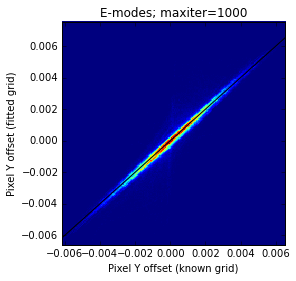

In [18]:
plt.figure(figsize=(4,4))
#create a new rectilinear grid for reference vertex positions
ideal_grid = Source(num_x=y_size,num_y=x_size)
_ = plt.hist2d((grid_to_fit.vertices[:,:,0]-ideal_grid.vertices[:,:,0]).flatten(),
               (distorted_grid.source.vertices[:,:,0]-ideal_grid.vertices[:,:,0]).flatten(),bins=200)
plt.plot([-.12,.12],[-.12,.12],'k')
plt.xlabel('Pixel Y offset (known grid)')
plt.ylabel('Pixel Y offset (fitted grid)')
plt.title('E-modes; maxiter=1000')